# Importing libraries

In [1]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from stingray.pulse import epoch_folding_search
from stingray.pulse import get_orbital_correction_from_ephemeris_file
import Important_Functions as IF
import scipy.stats as st
from importlib import reload
from stingray import Lightcurve
import lmfit as lf

/opt/anaconda3/envs/testenv/lib/python3.10/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/opt/anaconda3/envs/testenv/lib/python3.10/site-packages/stingray/utils.py:40: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


# Defining parameters 

In [2]:
##FOR RETRIEVING DATA
initial_path = '/Users/samsonmercier/Desktop/UNIGE/ap-lab-i-2022/data/'
sourcename = 'cen-x-3'
obsid = '/30101055002'
foldername = initial_path + sourcename + obsid + '/obs_lc'
#Making a path to folder where we store the saved pdfs 
general_save_path = '/Users/samsonmercier/Desktop'

#FOR ORBITAL CORRECTION
#Whether or not to perform orbital correction for source
use = True
#Whether or not to perform orbital correction for background
use_bc = True

#FOR DETERMINING THE PULSE FREQUENCY
#Distance from the periodogram's best frequency to probe 
#with epoch folding search 
dist = 2e-3
#Frequency at which we want to cutoff the low end of the periodogram
cutoff = 1e-3
#Whether we use the singular dataset or the concatenated one 
use_single = True
#Number of frequencies to test between the low and high end of 
#frequency range
N = 1000
#Length of segments in periodogram
seg_length = 20000
#Bin size for Lightcurve 
PF_dt = 0.1

#FOR MAKING THE PULSE PROFILE
#Bin size for pulse profile - used for stingray lightcurve (detailed in module)
PP_dt = 0.01
#Whether or not to save pulse profile
save_PP = True
#Path to where we save the pulse profile matrix pdf
save_path_PP = general_save_path+'/Pulse_Profile.pdf'


#FOR MAKING THE LIGHTCURVE (PLOTTING PURPOSES MOSTLY)
#Bin size for lightcurve
lc_dt = 10
#Whether or not to save pulse profile
save_LC = True
#Path to where we save the pulse profile matrix pdf
save_path_LC = general_save_path+'/Light_Curve.pdf'



#BINNING SOURCE DATA ENERGY-WISE
#Number of segments to make
num_segments = -75
#Energy range of events to consider
#Energy values are in PI in this case, they are converted to keV later
E_min = 120
E_max = 2800
#Whether or not to concatenate the segments so that they reach
#a minimum number of points
concat = True
#Threshold to use for the minimum number of data points
#we want in each segment - only used if concat is True
threshold = 1500


#BINNING SOURCE DATA TIME-WISE
#Number of segments to make
num_time_segments = 75

#MAKING TIME PULSE PROFILE MATRIX
#Bin size for pulse profiles in the matrix
T_dt = 0.01
#Confidence level for finding order of sinusoidal model of each pulse profile
conf = 0.1
#Whether or not to plot the errors of each pulse profile
account_errs = True
#Title to use for the pulse profile matrix generated
title = 'Time Pulse Profile Matrix'
#Whether or not we want to save the pulse profile matrix to a pdf
save=True
#Path to where we save the pulse profile matrix pdf
save_path_TPPM = general_save_path+'/Time_Pulse_Profile_Matrix.pdf'



#MAKING ENERGY PULSE PROFILE MATRIX
#Bin size for pulse profiles in the matrix
E_dt = 0.005
#Confidence level for finding order of sinusoidal model of each pulse profile
E_conf = 0.1
#Whether or not to plot the errors to each pulse profile
E_account_errs = False
#Title to use for the pulse profile matrix generated
E_title = 'Energy Pulse Profile Matrix'
#Whether or not we want to save the pulse profile matrix to a pdf
#The same path as the time pulse profile matrix is used.
E_save=True
#Path to where we save the pulse profile matrix pdf
save_path_EPPM = general_save_path+'/Energy_Pulse_Profile_Matrix.pdf'

#MAKING THE TIME-PHASE PLOT
save_path_time_phase = general_save_path+'/Time_phase.pdf'

#MAKING THE PULSED FRACTION PLOT
#Setting the number of Poisson distribution realizations
#used in the bootstrap method
num_realizations = 1000
#conversion from PI to keV
PI_conver = 4e-2
#whether or not to save the Pulsed fraction plot
PF_save = True
#Path to where we save the Pulsed fraction plot
save_path_PF = general_save_path+'/Pulsed_Fraction.pdf'


#BINNING BACKGROUND DATA ENERGY-WISE
#Number of segments
num_bc_segs = num_segments
#Energy range of events we consider
B_E_min = E_min
B_E_max = E_max



# Analyzing source data

## Retrieve the data for two data sets

In [3]:
#Retrieving data for source file
Time_phase_file_A = pf.open(foldername+'/sourceA.evt')
Time_phase_file_B = pf.open(foldername+'/sourceB.evt')

#Getting event arrival time data
Time_phase_data_A=Time_phase_file_A[1].data
Time_phase_data_B=Time_phase_file_B[1].data


## Get GTIs for datasets

In [4]:
#Extracting the GTIs from the source's GTI file
new_gti_A = IF.get_GTIs(Time_phase_file_A[2])
new_gti_B = IF.get_GTIs(Time_phase_file_B[2])

#The two GTI array have essentially the same values so we set 
new_gti = new_gti_A

## Orbitally correcting the arrival times

In [5]:
if use:
    correct_orbital_time_A = IF.get_orbital_correction(Time_phase_file_A[1], foldername+'/orbit_t2.txt')
    correct_orbital_time_B = IF.get_orbital_correction(Time_phase_file_B[1], foldername+'/orbit_t2.txt')

/opt/anaconda3/envs/testenv/lib/python3.10/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Assuming events are already referred to the solar system barycenter (timescale is TDB)
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
2023-01-10 09:57:14.648 | DEBUG    | pint.toa:__init__:1310 - No pulse number flags found in the TOAs
2023-01-10 09:57:14.648 | DEBUG    | pint.toa:compute_TDBs:2139 - Computing TDB columns.
2023-01-10 09:57:14.649 | DEBUG    | pint.toa:compute_TDBs:2164 - Using EPHEM = DE405 for TDB calculation.
2023-01-10 09:57:14.720 | DEBUG    | pint.toa:compute_posvels:2255 - Computing PosVels of observatories and Earth, using DE405
2023-01-10 09:57:14.729 | DEBUG    | pint.toa:compute_posvels:2310 - SSB obs pos [0. 0. 0.] m
2023-01-10 09:57:15.185 | INFO     | pint.solar_system_ephemerides:_load_kernel_link:54 - Set solar system ephemeris to de405 from download
2023-01-10 09:57:15.214 | DEBUG    | pint.toa:compute_posvels:2324 - Adding columns ssb_

## Concatenating data for the two events and sorting them to maintain order

In [6]:
#Concatenating the time and energy arrays
if use:
    correct_time = np.concatenate((correct_orbital_time_A, correct_orbital_time_B))
else:
    correct_time = np.concatenate((Time_phase_data_A['TIME'], Time_phase_data_B['TIME']))
    
total_energies = np.concatenate((Time_phase_data_A['PI'], Time_phase_data_B['PI']))

#Sorting the time and energy arrays because 
#the time arrays from both modules overlap
ind = np.argsort(correct_time)

total_correct_time = correct_time[ind]
total_correct_energies = total_energies[ind]

#Reference time used for the phase folding
ref_time = total_correct_time[0]

## Using the event arrival times with orbital correction and the Stingray function epoch_folding_search to find pulse frequency

Starting periodogram


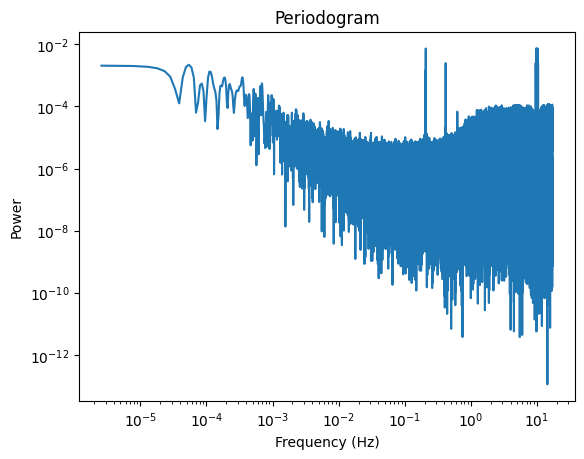

Finished periodogram step, found frequency: 0.20821934071823806
Now using Epoch-Folding Search around frequencies [ 0.20621934071823805 , 0.21021934071823806 ]
Finished epoch folding step, found frequency: 0.20821733871623604
Refinement on the pulse frequency of: 2.0020020020106166e-06 Hz


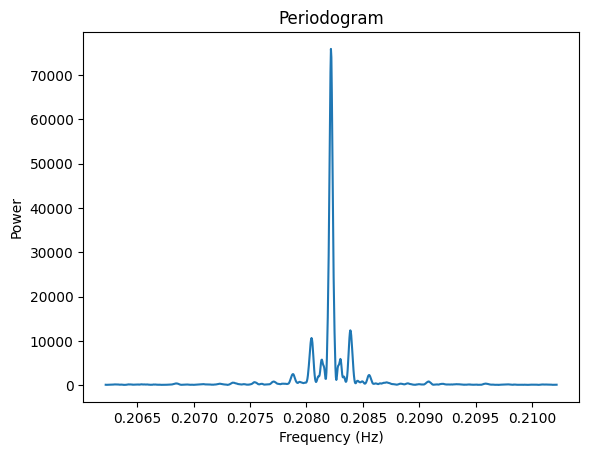

In [7]:
reload(IF)

#Using the orbital correction is recommended for this step 
correct_list, guess_freq, periodo_freq = IF.get_pulse_freq(N, total_correct_time, use_single, 
                                             correct_orbital_time_A, new_gti,  
                                             dist, seg_length, cutoff, PF_dt)

#Plotting the power as a function energy
plt.plot(correct_list[0], correct_list[1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Periodogram')
plt.show()

#The pulse frequency obtained from epoch_folding search
pulse_freq = [guess_freq]


## Plotting the pulse profile from the pulse frequency

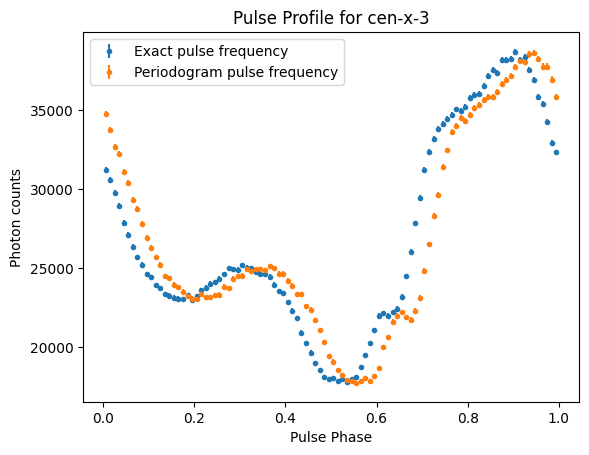

In [8]:
#Making a pulse profile from the best frequency obtain by the periodogram + epoch folding search

#Phase folding time
folded_time = IF.phase_fold(total_correct_time[0], total_correct_time, pulse_freq)
#Create a lightcurve
new_l = Lightcurve.make_lightcurve(folded_time, PP_dt)
#Compute the error bars - Counts are POissonian
errors = np.sqrt(new_l.counts)

#Making a pulse profile from the best frequency obtain by the periodogram + epoch folding search

#Phase folding time
folded_time_2 = IF.phase_fold(total_correct_time[0], total_correct_time, [periodo_freq])
#Create a lightcurve
new_l_2 = Lightcurve.make_lightcurve(folded_time_2, PP_dt)
#Compute the error bars - Counts are Poissonian
errors_2 = np.sqrt(new_l_2.counts)

#Plotting the two pulse profiles
plt.errorbar(new_l.time, new_l.counts, yerr=errors, fmt='.', label='Exact pulse frequency')
plt.errorbar(new_l_2.time, new_l_2.counts, yerr=errors_2, fmt='.', label='Periodogram pulse frequency')

plt.xlabel('Pulse Phase')
plt.ylabel('Photon counts')
plt.title('Pulse Profile for '+sourcename)
plt.legend()

#Saving our results
if save_PP:
    plt.savefig(save_path_PP)
plt.show()

## Plotting the Lightcurve with and without GTIs

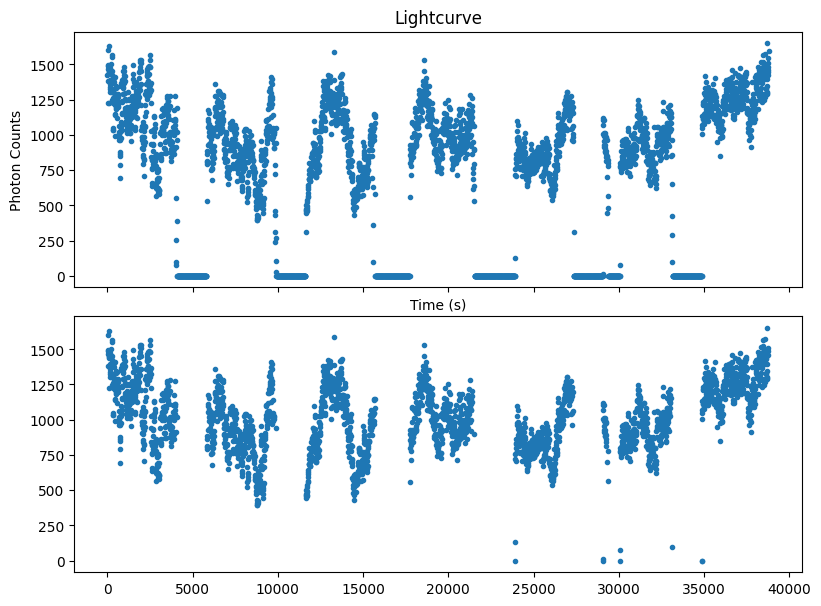

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.tight_layout()

#Making a lightcurve
tc = Lightcurve.make_lightcurve(total_correct_time, lc_dt, gti=new_gti)
ax1.plot(tc.time-total_correct_time[0], tc.counts, '.')
ax1.set_ylabel('Photon Counts')
ax1.set_title('Lightcurve')

#Keeping only the GTIs
tc.apply_gtis()
ax2.plot(tc.time-total_correct_time[0], tc.counts, '.')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Photon Counts')

#Saving our results
if save_LC:
    plt.savefig(save_path_LC, bbox_inches='tight')

## Segmenting our data Energy-wise

In [10]:
reload(IF)

energy_time_segments, energy_segments = IF.segment_energywise(total_correct_time, 
                                                              total_correct_energies, 
                                                              E_min, E_max, num_segments, threshold, concat)

## Segmenting our data Time-wise

In [11]:
reload(IF)

time_segs = IF.segment_timewise(total_correct_time, num_time_segments)

## Check the time pulse profile matrix to make sure the orbital correction was OK

Found an order of  7  with our chi-squared minimization routine.


Found an order of  7  with our chi-squared minimization routine.


Found an order of  7  with our chi-squared minimization routine.


Found an order of  10  with our chi-squared minimization routine.


Found an order of  10  with our chi-squared minimization routine.


Found an order of  7  with our chi-squared minimization routine.


Found an order of  6  with our chi-squared minimization routine.


Found an order of  6  with our chi-squared minimization routine.


Found an order of  6  with our chi-squared minimization routine.


Found an order of  6  with our chi-squared minimization routine.


Found an order of  5  with our chi-squared minimization routine.


Found an order of  4  with our chi-squared minimization routine.


Found an order of  49  with our chi-squared minimization routine.


Found an order of  4  with our chi-squared minimization routine.


Found an order of  11  with our chi-squared minimization ro

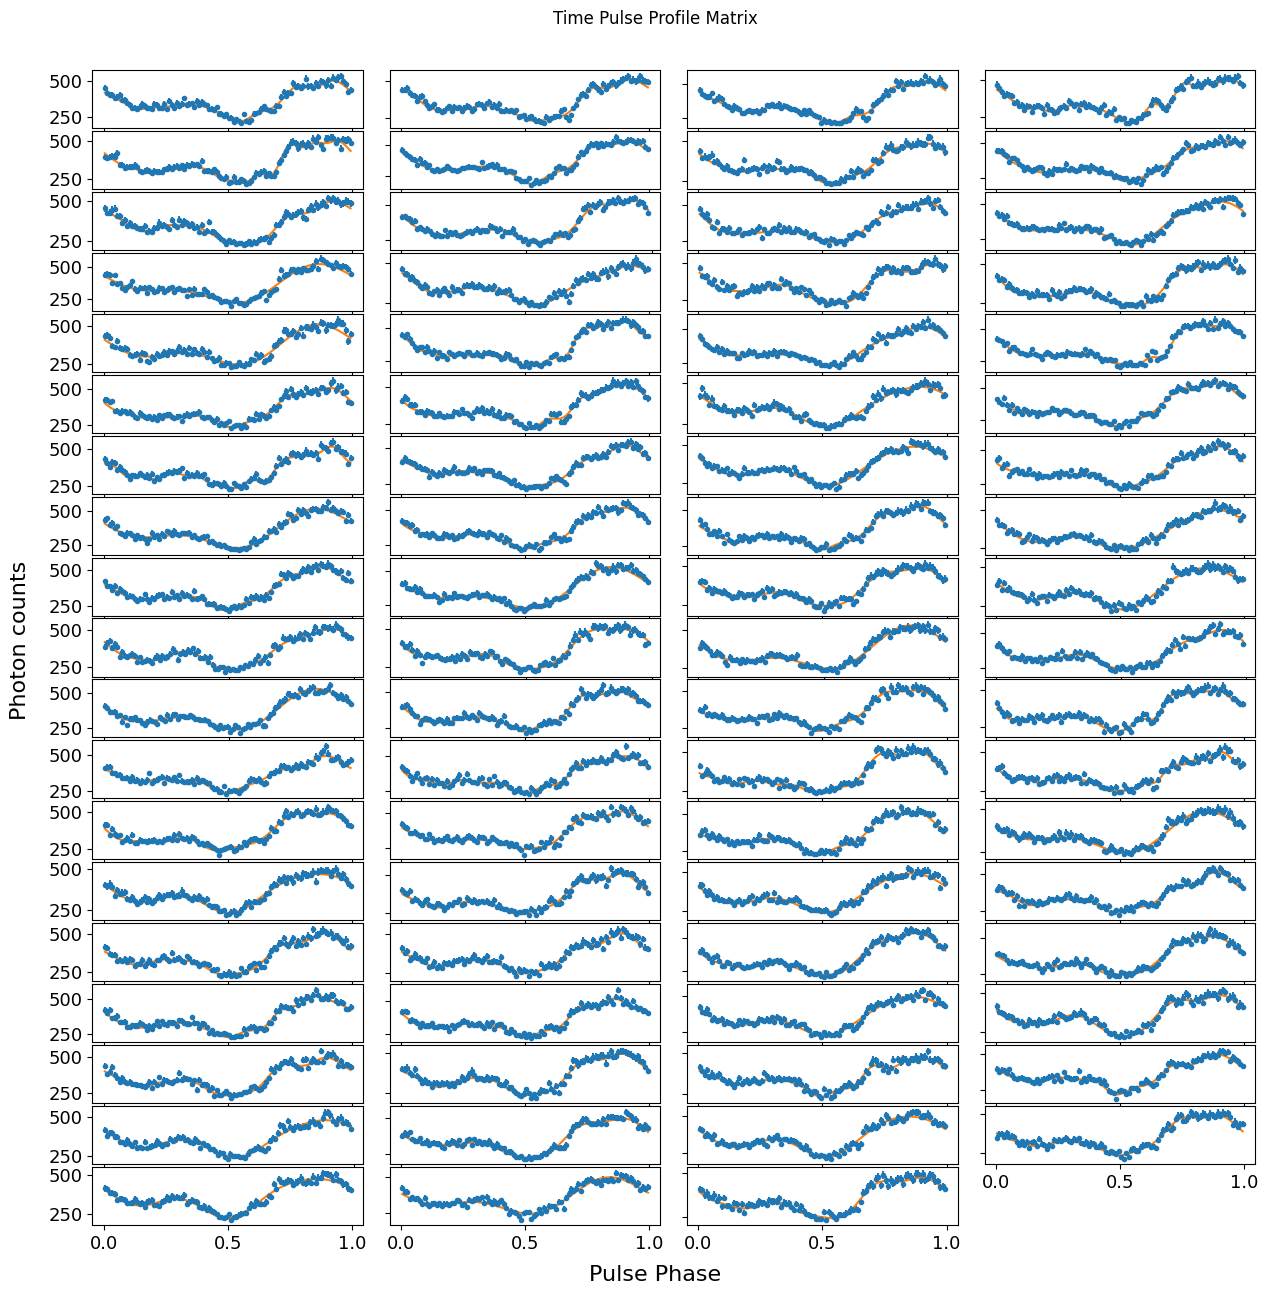

In [12]:
reload(IF)

orders, model_phases, counts, phasefold_time=IF.pulse_profile_matrix(time_segs, 
                                                                    ref_time, 
                                                                    pulse_freq, title, 
                                                                    T_dt, conf, 
                                                                     account_errs, save, save_path_TPPM)


## Make the energy pulse profile matrix 

Found an order of  7  with our chi-squared minimization routine.


Found an order of  3  with our chi-squared minimization routine.


Found an order of  3  with our chi-squared minimization routine.


Found an order of  2  with our chi-squared minimization routine.


Found an order of  9  with our chi-squared minimization routine.


Found an order of  6  with our chi-squared minimization routine.


Found an order of  9  with our chi-squared minimization routine.


Found an order of  6  with our chi-squared minimization routine.


Found an order of  7  with our chi-squared minimization routine.


Found an order of  99  with our chi-squared minimization routine.


Found an order of  6  with our chi-squared minimization routine.


Found an order of  7  with our chi-squared minimization routine.


Found an order of  24  with our chi-squared minimization routine.


Found an order of  6  with our chi-squared minimization routine.


Found an order of  99  with our chi-squared minimization rou

/Users/samsonmercier/Desktop/UNIGE/ap-lab-i-2022/notebooks/Important_Functions.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  Xi+=((model[i]-expec[i])/uncertainty[i])**2


Found an order of  98  with our chi-squared minimization routine.


Found an order of  98  with our chi-squared minimization routine.




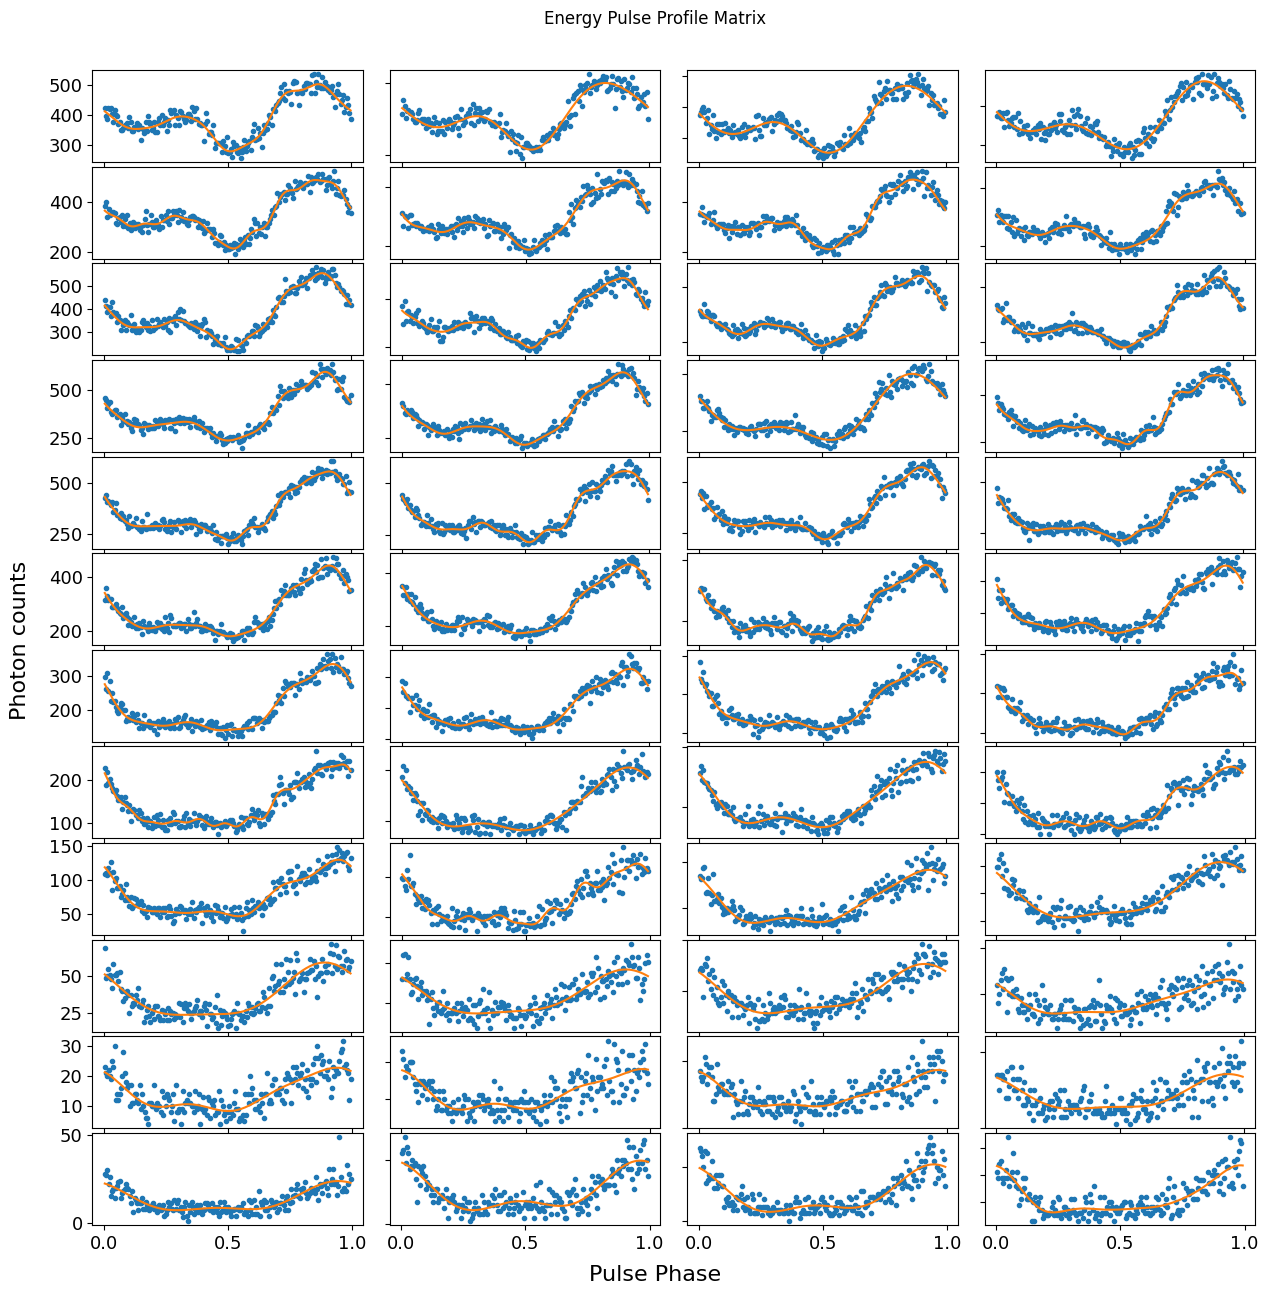

In [13]:
reload(IF)

energy_orders, energy_model_phases, energy_counts, energy_phasefold_time=IF.pulse_profile_matrix(energy_time_segments, ref_time, 
                                                            pulse_freq, E_title, 
                                                             E_dt, E_conf, E_account_errs, E_save, save_path_EPPM)


## Making the Pulsed Fraction plot

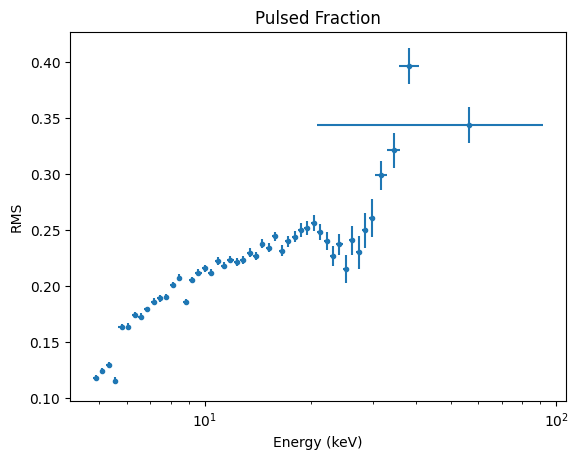

In [14]:
reload(IF)

#We calculate the pulsed fraction using the RMS
#Initializing:
#the RMS values for each segment
RMSs = np.zeros(len(energy_counts))

#the error on the RMS value for each segment - obtained from bootstrap method
RMS_error = np.ones(len(energy_counts))

#the average energy for each segment
avg = np.zeros(len(energy_counts))

#the error on the average energy of each segment 
E_rror = np.ones(len(energy_counts))

#Populating the arrays defined above, by iterating over the pulse profiles in the matrix 
for i in range(len(energy_counts)):
    
    #Getting the error on the RMS values from the bootstraping method
    RMS_error[i] = IF.bootstrap_total(energy_counts[i], num_realizations, IF.RMS_calculator, energy_orders[i])
    
    #Getting the RMS from our RMS_calculator function
    RMSs[i] = IF.RMS_calculator(energy_counts[i], energy_orders[i])
    
    #Getting the average energy in each segment
    avg[i] = np.mean(energy_segments[i]*PI_conver)
    
    #Getting the error on the average energy
    E_rror[i] = 0.5*(max(energy_segments[i]*PI_conver)-min(energy_segments[i]*PI_conver))
    
#Plotting the RMS against the average energy for each segment
fig, ax = plt.subplots(1, 1)
ax.errorbar(avg, RMSs, xerr=E_rror, yerr=RMS_error, fmt='.')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('RMS')
ax.set_title('Pulsed Fraction')
ax.set_xscale('log')

## Making the Time vs Phase plot

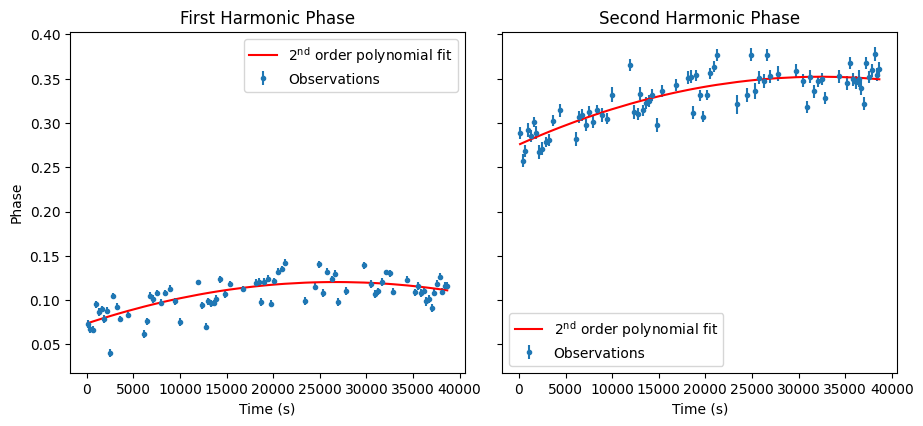

In [15]:
reload(IF)

#Plotting the phase of first and second harmonics for each pulse profile
#This tells us whether we determined the pulse frequency correctly or not
params_first, params_second = IF.plot_time_vs_phase(time_segs, counts, model_phases, E_save, save_path_time_phase)

## Correcting the pulse frequency

In [16]:
#We use the best-fit parameters from the fit of the Time-phase plot 
#for the first harmonics to update the pulse frequency and our phase-folding function.

#We multiply by 2 to account for the factorial terms present in the Taylor expansion 
#used in our phase-folding function.
new_pulse_freq = [guess_freq+params_first[1], 2*params_first[0]]

## Re-make time pulse profile matrix

Found an order of  7  with our chi-squared minimization routine.


Found an order of  49  with our chi-squared minimization routine.


Found an order of  12  with our chi-squared minimization routine.


Found an order of  49  with our chi-squared minimization routine.


Found an order of  9  with our chi-squared minimization routine.


Found an order of  9  with our chi-squared minimization routine.


Found an order of  6  with our chi-squared minimization routine.


Found an order of  7  with our chi-squared minimization routine.


Found an order of  4  with our chi-squared minimization routine.


Found an order of  7  with our chi-squared minimization routine.


Found an order of  4  with our chi-squared minimization routine.


Found an order of  4  with our chi-squared minimization routine.


Found an order of  49  with our chi-squared minimization routine.


Found an order of  9  with our chi-squared minimization routine.


Found an order of  10  with our chi-squared minimization r

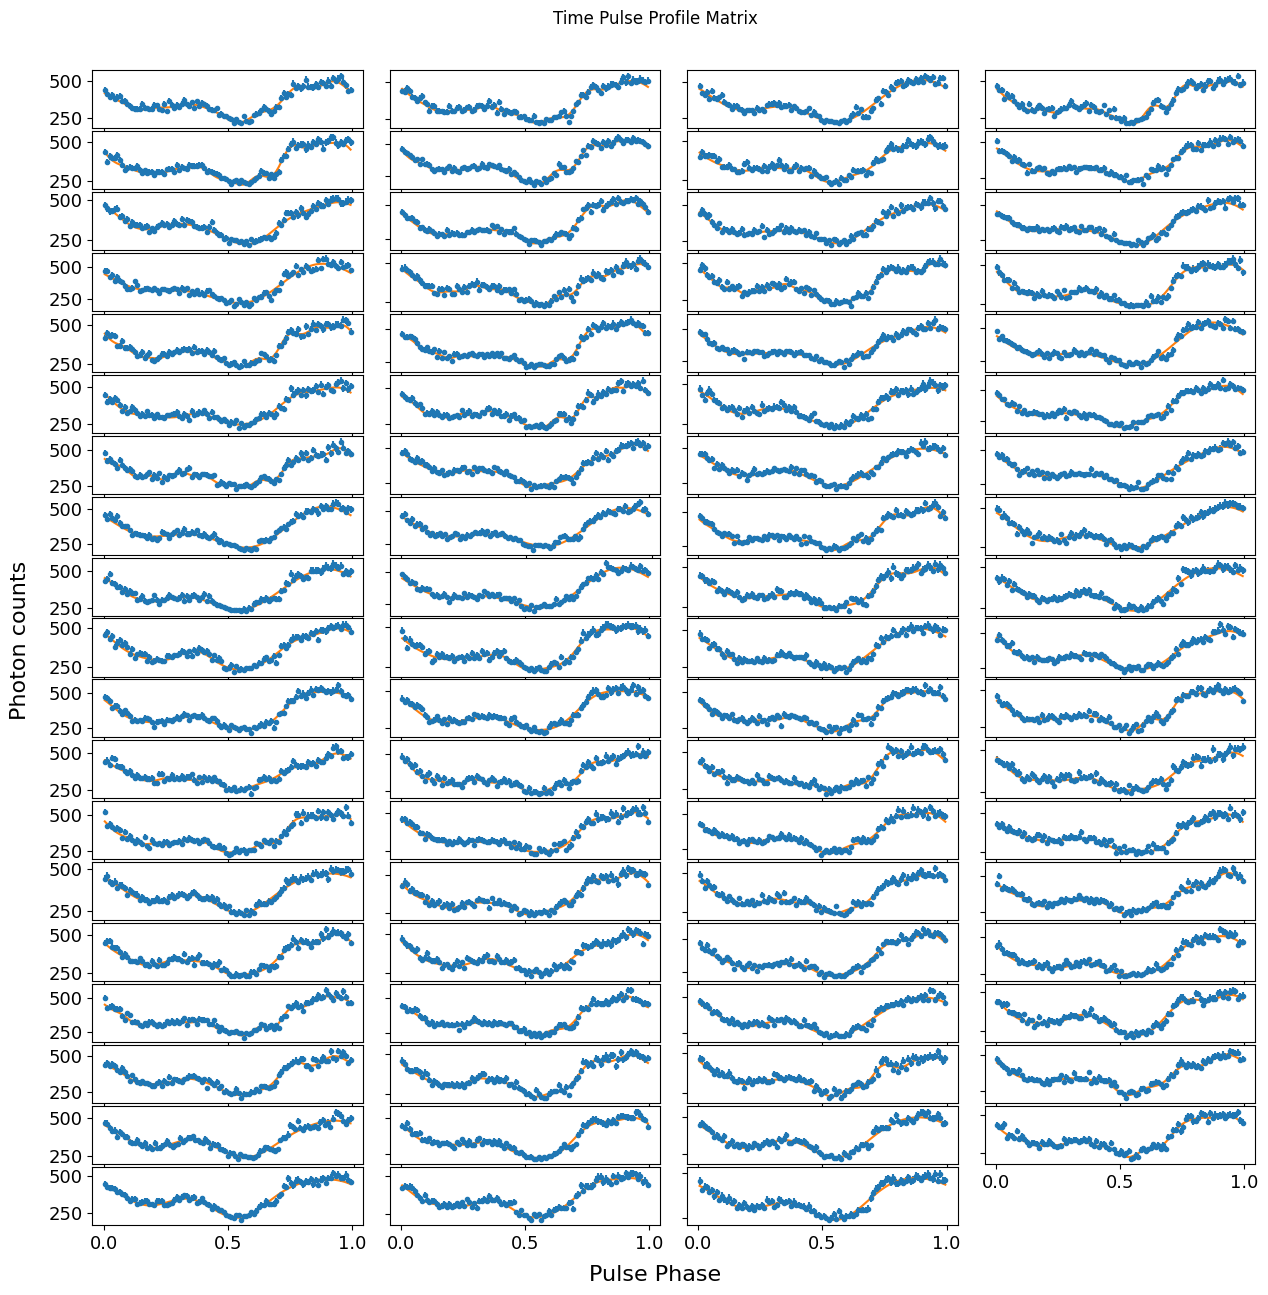

In [17]:
reload(IF)

improv_orders, improv_model_phases, improv_counts, improv_phasefold_time=IF.pulse_profile_matrix(time_segs, 
                                                                    ref_time, 
                                                                    new_pulse_freq, title, 
                                                                     T_dt, conf, 
                                                                     account_errs, save, save_path_TPPM)


## Re-making the Time phase plot to make sure our correction worked

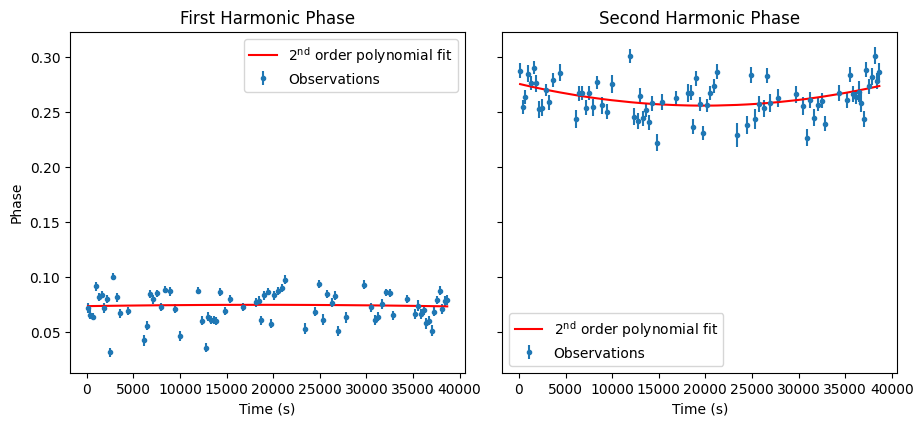

In [18]:
reload(IF)
params_first_prime, params_second_prime = IF.plot_time_vs_phase(time_segs, improv_counts, 
                                                                improv_model_phases, E_save, save_path_time_phase)

## Re-making the energy pulse profile matrix and the corresponding RMS plot

Found an order of  6  with our chi-squared minimization routine.


Found an order of  6  with our chi-squared minimization routine.


Found an order of  99  with our chi-squared minimization routine.


Found an order of  3  with our chi-squared minimization routine.


Found an order of  26  with our chi-squared minimization routine.


Found an order of  99  with our chi-squared minimization routine.


Found an order of  6  with our chi-squared minimization routine.


Found an order of  7  with our chi-squared minimization routine.


Found an order of  7  with our chi-squared minimization routine.


Found an order of  11  with our chi-squared minimization routine.


Found an order of  9  with our chi-squared minimization routine.


Found an order of  7  with our chi-squared minimization routine.


Found an order of  10  with our chi-squared minimization routine.


Found an order of  9  with our chi-squared minimization routine.


Found an order of  20  with our chi-squared minimization 

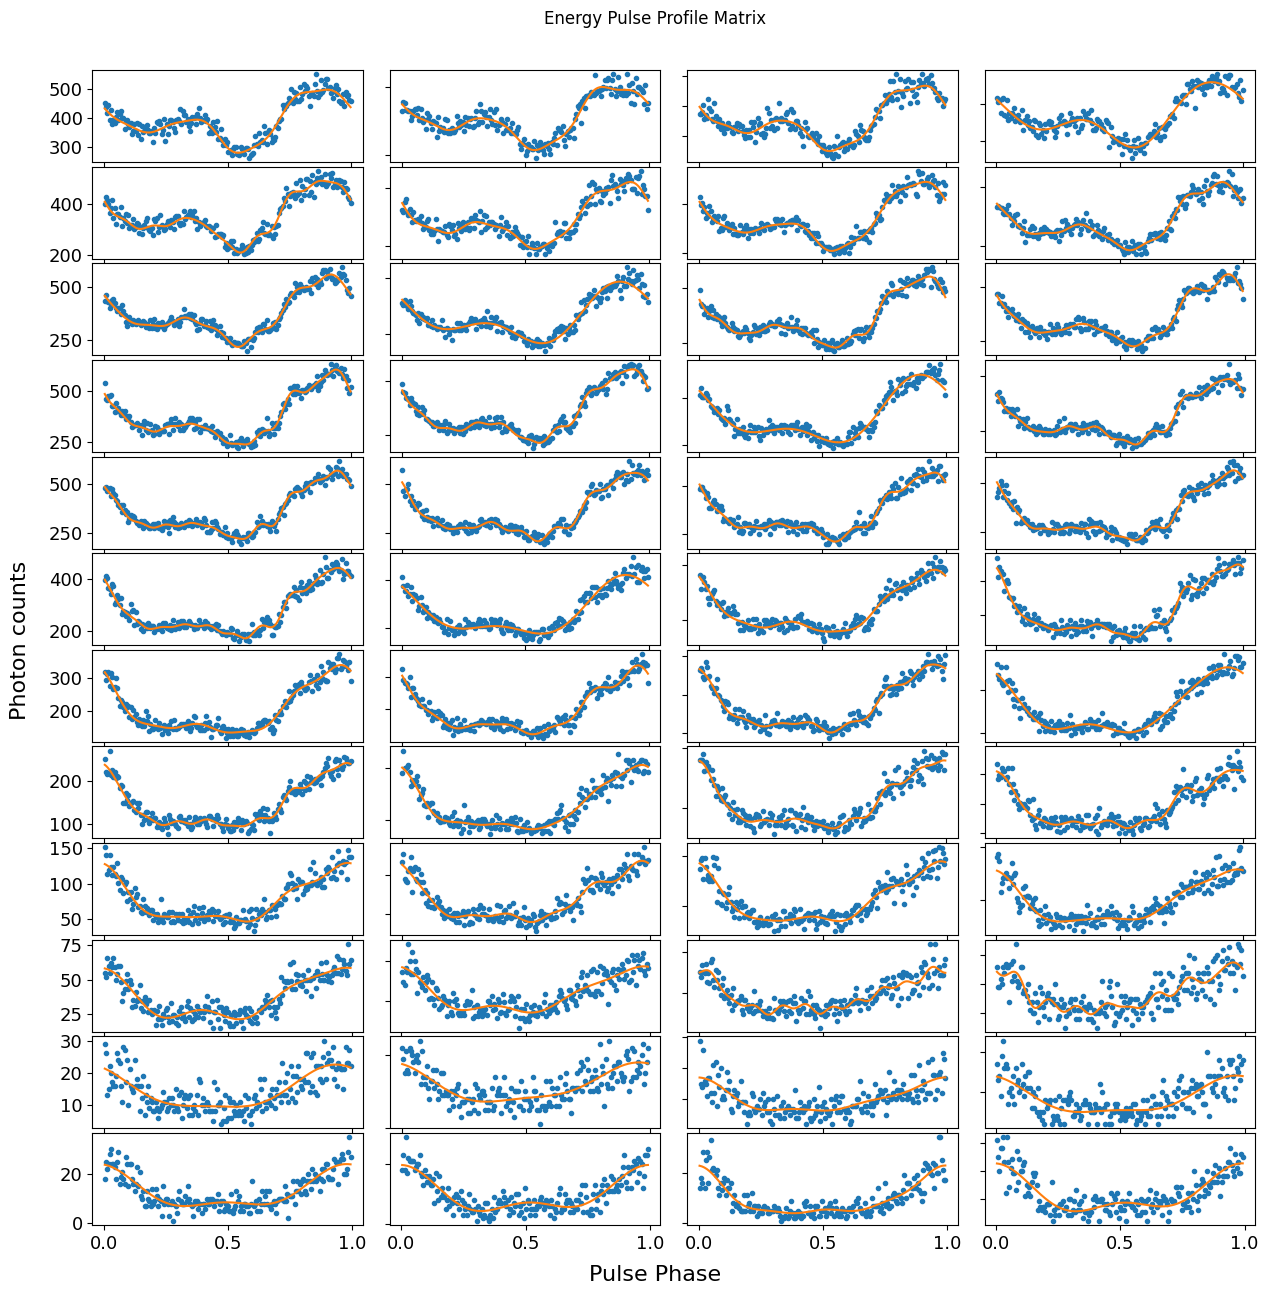

In [19]:
reload(IF)

improv_energy_orders, improv_energy_model_phases, improv_energy_counts, improv_energy_phasefold_time=IF.pulse_profile_matrix(energy_time_segments, ref_time, 
                                                            new_pulse_freq, E_title, E_dt, E_conf, E_account_errs, E_save, save_path_EPPM)


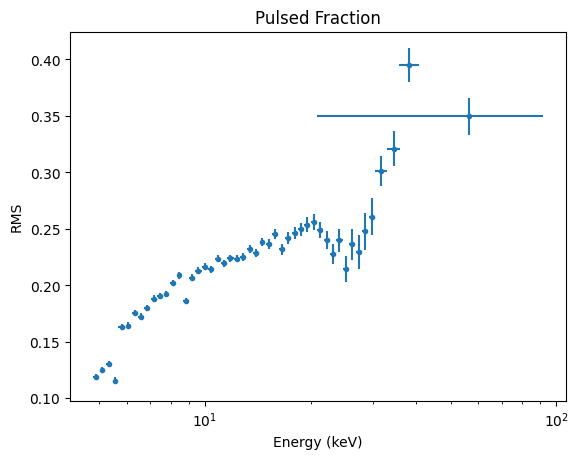

In [20]:
reload(IF)

#We calculate the pulsed fraction using the RMS
#Initializing:
#the RMS values for each segment
RMSs = np.zeros(len(improv_energy_counts))

#the error on the RMS value for each segment - obtained from bootstrap method
RMS_error = np.ones(len(improv_energy_counts))

#the average energy for each segment
avg = np.zeros(len(improv_energy_counts))

#the error on the average energy of each segment 
E_rror = np.ones(len(improv_energy_counts))

#Populating the arrays defined above, by iterating over the pulse profiles in the matrix 
for i in range(len(improv_energy_counts)):
    
    #Getting the error on the RMS values from the bootstraping method
    RMS_error[i] = IF.bootstrap_total(improv_energy_counts[i], num_realizations, IF.RMS_calculator, energy_orders[i])
    
    #Getting the RMS from our RMS_calculator function
    RMSs[i] = IF.RMS_calculator(improv_energy_counts[i], energy_orders[i])
    
    #Getting the average energy in each segment
    avg[i] = np.mean(energy_segments[i]*PI_conver)
    
    #Getting the error on the average energy
    E_rror[i] = 0.5*(max(energy_segments[i]*PI_conver)-min(energy_segments[i]*PI_conver))
    
#Plotting the RMS against the average energy for each segment
fig, ax = plt.subplots(1, 1)
ax.errorbar(avg, RMSs, xerr=E_rror, yerr=RMS_error, fmt='.')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('RMS')
ax.set_title('Pulsed Fraction')
ax.set_xscale('log')

# Taking into account the background

## Importing the background data

In [43]:
#Retrieving data from background file
Time_phase_file_bc_A = pf.open(foldername+'/backgroundA.evt')
Time_phase_file_bc_B = pf.open(foldername+'/backgroundB.evt')

#Getting event arrival time data
Time_phase_data_bc_A=Time_phase_file_bc_A[1].data
Time_phase_data_bc_B=Time_phase_file_bc_B[1].data

## Orbitally correcting the event arrival times

In [44]:
if use_bc:
    correct_orbital_time_bc_A = IF.get_orbital_correction(Time_phase_file_bc_A[1], foldername+'/orbit_t2.txt')
    correct_orbital_time_bc_B = IF.get_orbital_correction(Time_phase_file_bc_B[1], foldername+'/orbit_t2.txt')

/opt/anaconda3/envs/testenv/lib/python3.10/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Assuming events are already referred to the solar system barycenter (timescale is TDB)
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
2023-01-10 10:18:07.209 | DEBUG    | pint.toa:__init__:1310 - No pulse number flags found in the TOAs
2023-01-10 10:18:07.209 | DEBUG    | pint.toa:compute_TDBs:2139 - Computing TDB columns.
2023-01-10 10:18:07.210 | DEBUG    | pint.toa:compute_TDBs:2164 - Using EPHEM = DE405 for TDB calculation.
2023-01-10 10:18:07.279 | DEBUG    | pint.toa:compute_posvels:2255 - Computing PosVels of observatories and Earth, using DE405
2023-01-10 10:18:07.287 | DEBUG    | pint.toa:compute_posvels:2310 - SSB obs pos [0. 0. 0.] m
2023-01-10 10:18:07.730 | INFO     | pint.solar_system_ephemerides:_load_kernel_link:54 - Set solar system ephemeris to de405 from download
2023-01-10 10:18:07.757 | DEBUG    | pint.toa:compute_posvels:2324 - Adding columns ssb_

## Get GTIs for datasets

In [45]:
#Extracting the GTIs from the background's GTI file
new_gti_bc_A = IF.get_GTIs(Time_phase_file_A[2])
new_gti_bc_B = IF.get_GTIs(Time_phase_file_B[2])

#The two GTI array have essentially the same values so we set 
new_gti_bc = new_gti_bc_A

## Concatenating data for the two events and sorting them to maintain order

In [46]:
#Concatenating the time and energy arrays
if use_bc:
    correct_time_bc = np.concatenate((correct_orbital_time_bc_A, correct_orbital_time_bc_B))
else:
    correct_time_bc = np.concatenate((Time_phase_data_bc_A['TIME'], Time_phase_data_bc_B['TIME']))

total_energies_bc = np.concatenate((Time_phase_data_bc_A['PI'], Time_phase_data_bc_B['PI']))

#Sorting the time and energy arrays because 
#the time arrays from both modules overlap
ind2 = np.argsort(correct_time_bc)

total_correct_time_bc = correct_time_bc[ind2]
total_correct_energies_bc = total_energies_bc[ind2]

#Reference time used for the phase folding
ref_time_bc = total_correct_time_bc[0]

## Segmenting our data Energy-wise

In [47]:
#Creating the bins to use for the background, from the bins used for the pulse profile

#Initializing
old_bins = np.ones(len(energy_segments)+1)

#Populating
for i in range(len(energy_segments)):
    old_bins[i] = min(energy_segments[i])

old_bins[-1] = max(energy_segments[-1])

In [48]:
reload(IF)

energy_time_segments_bc, energy_segments_bc = IF.segment_energywise(total_correct_time_bc, 
                                                              total_correct_energies_bc, B_E_min, 
                                                                    B_E_max, num_bc_segs, threshold, old_bins, load=True)

## Getting energy pulse profile for background

/Users/samsonmercier/Desktop/UNIGE/ap-lab-i-2022/notebooks/Important_Functions.py:413: RuntimeWarning: divide by zero encountered in double_scalars
  Returns


Found an order of  91  with our chi-squared minimization routine.


Found an order of  97  with our chi-squared minimization routine.


Found an order of  95  with our chi-squared minimization routine.


Found an order of  91  with our chi-squared minimization routine.


Found an order of  87  with our chi-squared minimization routine.


Found an order of  90  with our chi-squared minimization routine.


Found an order of  94  with our chi-squared minimization routine.


Found an order of  97  with our chi-squared minimization routine.


Found an order of  87  with our chi-squared minimization routine.


Found an order of  98  with our chi-squared minimization routine.


Found an order of  89  with our chi-squared minimization routine.


Found an order of  95  with our chi-squared minimization routine.


Found an order of  96  with our chi-squared minimization routine.


Found an order of  96  with our chi-squared minimization routine.


Found an order of  93  with our chi-squared mini

Found an order of  93  with our chi-squared minimization routine.


Found an order of  92  with our chi-squared minimization routine.


Found an order of  95  with our chi-squared minimization routine.


Found an order of  98  with our chi-squared minimization routine.




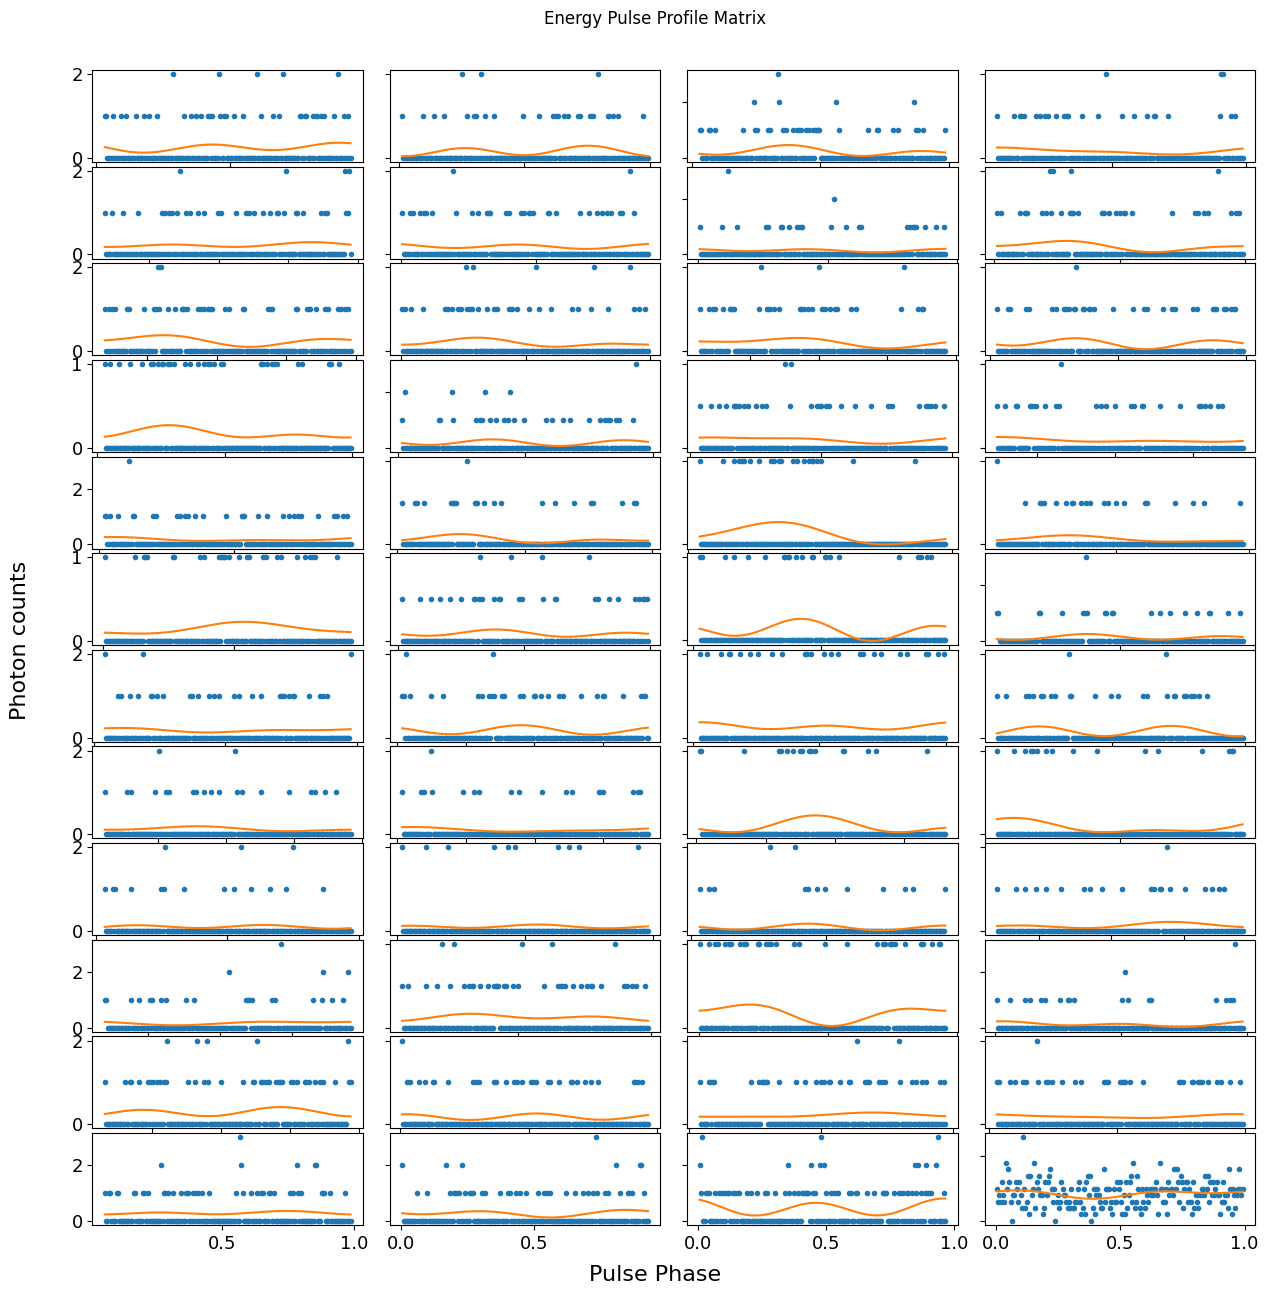

In [49]:
reload(IF)

energy_orders_bc, energy_model_phases_bc, energy_counts_bc, energy_phasefold_time_bc=IF.pulse_profile_matrix(energy_time_segments_bc, ref_time_bc, 
                                                            new_pulse_freq, E_title, E_dt, 
                                                            E_conf)


# Plotting the RMS with and without the background

## Removing the background energy counts from the source energy counts for each segment

In [50]:
#Initializing the list for energy counts with no background.
nobc_energy_counts=[]

#Populating the source minus background segments.
for i in range(len(energy_counts)):
    #From the source energy counts, we remove the average background energy counts obtained
    #from our pulse profile matrix for the background data.
    nobc_energy_count = np.array(energy_counts[i])-np.mean(energy_counts_bc[i])
    #Adding a condition in case the counts are negative. If the counts are negative, our bootstrapping
    #method would crash so we set them to 0 in this case. 
    for j in range(len(nobc_energy_count)):
        if nobc_energy_count[j] < 0:
            nobc_energy_count[j] = 0
    nobc_energy_counts.append(nobc_energy_count)

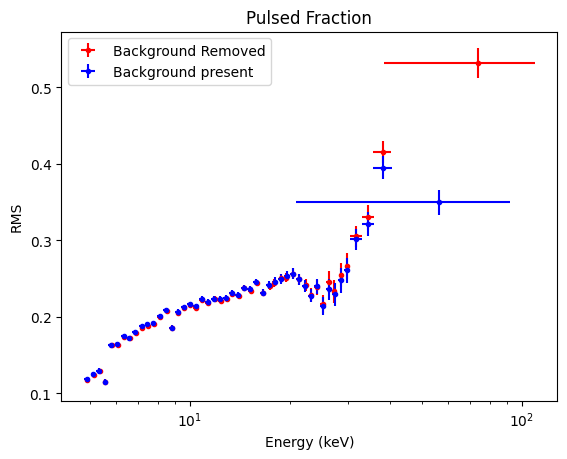

In [51]:
#Using the previously defined number of Poisson distribution realizations for the 
#bootstrap method

#Initializing:
#the RMS values for each segment
nobc_RMSs = np.zeros(len(energy_counts))

#the error on the RMS value for each segment - obtained from bootstrap method
nobc_RMS_error = np.ones(len(energy_counts))

#the average energy for each segment
nobc_avg = np.zeros(len(energy_counts))

#the error on the average energy of each segment 
nobc_E_rror = np.ones(len(energy_counts))


#Populating the arrays defined above, by iterating over the pulse profiles in the matrix 
for i in range(len(energy_counts)):
    
    #Getting the error on the RMS values from the bootstrap method
    nobc_RMS_error[i] = IF.bootstrap_total(nobc_energy_counts[i], num_realizations, IF.RMS_calculator, energy_orders[i])
    
    #Getting the RMS from our RMS_calculator function  
    nobc_RMSs[i] = IF.RMS_calculator(nobc_energy_counts[i], energy_orders[i])
    
    #Getting the average energy in each segment
    nobc_avg[i] = np.mean(energy_segments_bc[i]*PI_conver)
    
    #Getting the error on the average energy
    nobc_E_rror[i] = 0.5*(max(energy_segments_bc[i]*PI_conver)-min(energy_segments_bc[i]*PI_conver))

#Plotting the RMS against the average energy for each segment, both for the 
#case where the background is present (blue) and where the background 
#was removed (red).
fig, ax = plt.subplots(1, 1)
ax.errorbar(nobc_avg, nobc_RMSs, xerr=nobc_E_rror, yerr=nobc_RMS_error, fmt='r.', label='Background Removed')
ax.errorbar(avg, RMSs, xerr=E_rror, yerr=RMS_error, fmt='b.', label='Background present')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('RMS')
ax.legend()
ax.set_title('Pulsed Fraction')
ax.set_xscale('log')

#We save the figure.
if PF_save:
    plt.savefig(save_path_PF)
    

## Fitting the RMS plot

In [52]:
#We fit a 1st order polynomial to our pulsed fraction plot
#using the lmfit package.
def polynom(x, a, b):
    return a + b*x

#Building the model.
mod = lf.Model(polynom)

#Fitting the model.
result = mod.fit(nobc_RMSs[:-1], a=1, b=1, x=nobc_avg[:-1], weights=(1/nobc_RMS_error[:-1]))

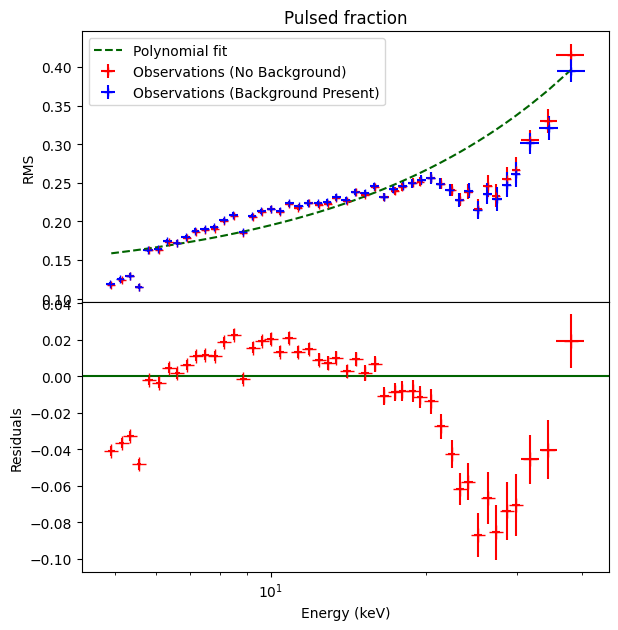

In [53]:
#We initiate the figure.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
fig.tight_layout()
plt.subplots_adjust(hspace=0)

#We plot the pulsed fraction with background removed
#and the bestfit to it.
ax1.errorbar(nobc_avg[:-1], nobc_RMSs[:-1], xerr=nobc_E_rror[:-1], yerr = nobc_RMS_error[:-1], fmt='r+', label='Observations (No Background)')
ax1.errorbar(avg[:-1], RMSs[:-1], xerr=E_rror[:-1], yerr = RMS_error[:-1], fmt='b+', label='Observations (Background Present)')
ax1.plot(nobc_avg[:-1], result.best_fit, '--', color='darkgreen', label='Polynomial fit')

ax2.errorbar(nobc_avg[:-1], nobc_RMSs[:-1] - result.best_fit, xerr=nobc_E_rror[:-1], yerr = nobc_RMS_error[:-1], fmt='r+', markersize=10)
ax2.axhline(y=0, color='darkgreen')

ax2.set_xlabel('Energy (keV)')
ax1.set_ylabel('RMS')
ax2.set_ylabel('Residuals')
ax1.set_title('Pulsed fraction')
ax1.set_xscale('log')
ax1.legend()

#Saving the figure.
if PF_save:
    plt.savefig(save_path_PF, bbox_inches='tight')


## Overleaf plotting - Showing the bootstrap realizations

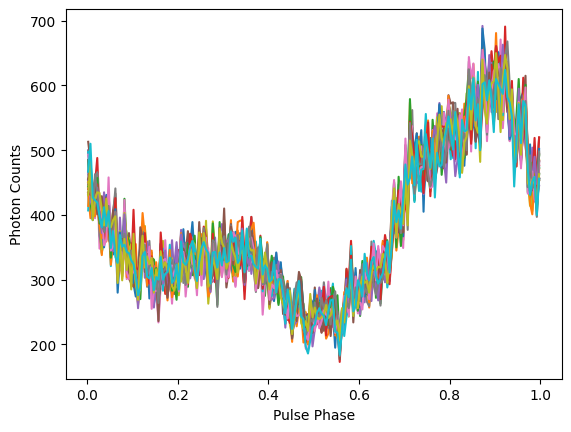

In [31]:
#Plotting the realizations of a single pulse profile
#for sanity check purposes.

#Number of realizations we want to make.
num_realize=30

#The pulse profile to use in the energy pulse profile matrix.
profile_to_use=12

#Iterating over the realizations and plotting each of them.
for i in range(num_realize):
    plt.plot(energy_phasefold_time[profile_to_use], IF.bootstrap_generate(energy_counts[profile_to_use], num_realize)[i])

plt.xlabel('Pulse Phase')
plt.ylabel('Photon Counts')
plt.savefig('/Users/samsonmercier/Desktop/Bootstrap.pdf')
plt.show()